In [41]:
#importing libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import yfinance as yf
import random
from scipy.optimize import minimize

In [42]:
#Start and end Date
end =datetime.today()
start = end - timedelta(days = 60)#change days
tickers = ['NVDA','TSLA','AMD','RIVN','AAPL','NIO','INTC','PLTR','SIRI','BBD','F','SOFI','LCID','AAL','AMZN','MARA','T','KVUE','SNAP','HBAN','PFE','MU','GME','CCL','VALE']#Change Tickers

In [43]:
#Get data from excel File
def get_excel_data():
    
    portfolio = pd.read_excel('/Users/kaloyanpanov/Documents/bocconi/Quant/CODE/TSLA.xlsx', sheet_name='TSLA') #change path
    
    return portfolio

In [44]:
def get_web_data(tickers):
    
    portfolio = pd.dataframe()
    for stock in tickers:
        stock = yf.download(stock,start,end)
        stock = stock['Adj Close']
        portfolio = pd.concat([portfolio,stock],axis=1)
    
    return portfolio

In [45]:
#Calculate log daily returns
def get_log_returns(portfolio):
    
    portfolio = portfolio.iloc[:, 1:]
    portfolio_log = np.log(portfolio / portfolio.shift(1))
    
    return portfolio_log.dropna()

In [48]:
portfolio = get_excel_data()
portfolio_log = get_log_returns(portfolio)

In [49]:
#Calculate covariance
portfolio_cov = portfolio_log.cov()
portfolio_cov

,Adj Close,Adj Close.1,Adj Close.2
Adj Close,0.001693,0.000413,0.000121
Adj Close.1,0.000413,0.000403,0.000112
Adj Close.2,0.000121,0.000112,0.000330


In [9]:
#Maybe a cov matrix
def ret_portfolio_cov(equity_cov,bonds_cov):
    equity_cov = np.array(equity_cov)
    bonds_cov = np.array(bonds_cov)
    portfolio_cov = block_diag(equity_cov,bonds_cov)
    portfolio_cov=pd.DataFrame(portfolio_cov)
    return portfolio_cov

In [50]:
#Find number of positions
N = len(portfolio.columns)

In [51]:
#Find random weights with sum 1 
def gen_weights(assets):
    
    weights = np.random.random(assets)
    weights = weights/sum(weights)
    
    return weights

In [52]:
#Find random weights with constraints
def generate_const_weights(N):
    
    initial_floats = np.random.uniform(0.00, 0.10, N)
    
    def objective(x):
        return np.sum((x - initial_floats) ** 2)
    #Countraint big positions with 40%
    def constraint_sum_range(x):
        return 0.40 - np.sum(x[(x >= 0.05)])
    #Contraint so no leverage
    def constraint_sum_at_most_one(x):
        return 1 - np.sum(x)
    #Constraint so at least 85% of capital is allocated 
    def constraint_sum_at_least(x):
        return np.sum(x) - 0.85
    #Bounds for random weights 
    bounds = [(0.00, 0.10) for _ in range(N)]
    
    constraints = [
        {'type': 'ineq', 'fun': constraint_sum_range},
        {'type': 'ineq', 'fun': constraint_sum_at_most_one},
        {'type': 'ineq', 'fun': constraint_sum_at_least}
    ]
    
    result = minimize(objective, initial_floats, constraints=constraints, bounds=bounds, options={'disp': False})
    
    floats = result.x
    
    return floats

In [90]:
generate_const_weights(3)

array([0.1, 0.1, 0.1])

In [78]:
#Calculates return of the portfolio
def calc_returns(portfolio_log_return,weights):
    
    portfolio_cuml_ret = np.sum(portfolio_log_return.mean()*weights)*252
                       
    return portfolio_cuml_ret

In [79]:
#Calculates volatility of the portfolio
def calc_vol(portfolio_cov,weights):
    
    annual_cov = np.dot(portfolio_cov*252,weights)
    vol = np.dot(weights.transpose(),annual_cov)
    
    return np.sqrt(vol)

In [80]:
weights = gen_weights(len(portfolio.columns)-1)
calc_vol(portfolio_cov,weights)

0.26947483661193566

In [81]:
#Monte Carlo Simulation
mc_return = []
mc_weights = []
mc_vol = []
for sim in range(100000):
    weights = gen_weights(len(portfolio.columns)-1)
    mc_weights.append(weights)
    returns = calc_returns(portfolio_log,weights)
    mc_return.append(returns)
    vol = calc_vol(portfolio_cov,weights)
    mc_vol.append(vol)
    

In [82]:
mc_sharpe = np.array(mc_return)/np.array(mc_vol)

In [83]:
mc_sharpe.argmax()

99126

In [88]:
mc_return[99126]

0.3779728288358755

In [87]:
mc_weights[99126]

array([0.11941822, 0.22159996, 0.65898182])

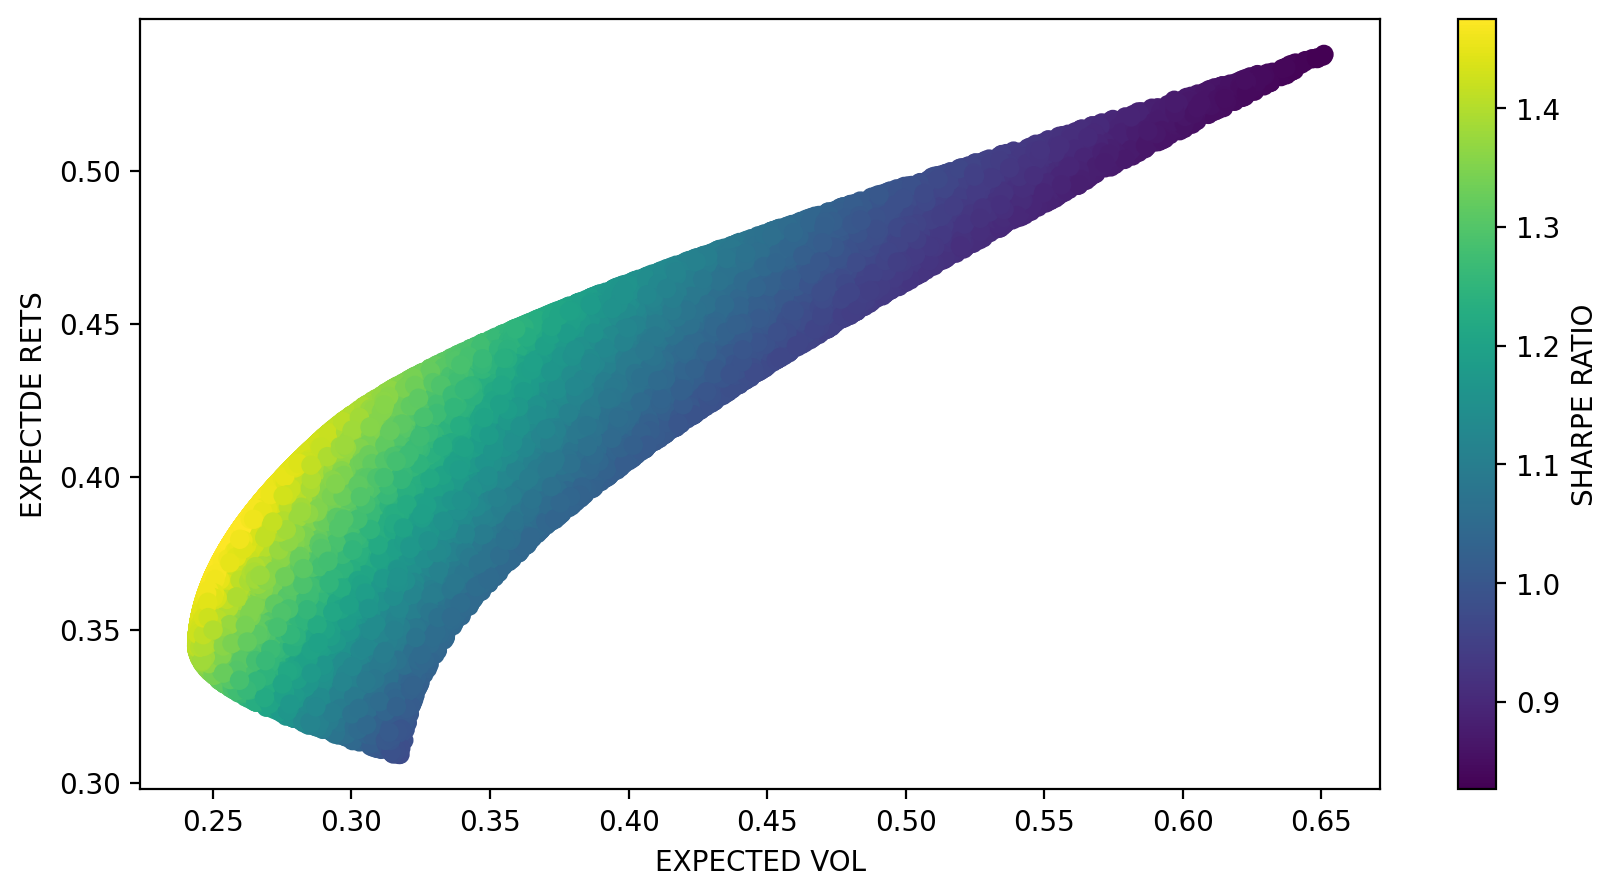

In [89]:
plt.figure(dpi=200,figsize=(10,5))
plt.scatter(mc_vol,mc_return,c=mc_sharpe)
plt.ylabel('EXPECTDE RETS')
plt.xlabel('EXPECTED VOL')
plt.colorbar(label="SHARPE RATIO");